In [17]:
import pandas as pd
import warnings
import numpy as np
import os
import yfinance as yf
from adjustments import get_AMZN_adustments_df, get_tsmc_adjustments_df, get_nvda_adjustments_df, get_exchange_rate_df

warnings.filterwarnings('ignore')

original_features = ["AMZN", "GOOG", "MSFT", "META", "SMCI", "TSMC-Revenue"]

test_set_row_len = 1
USE_BOUNDS = True # use bounds for the features, no-feature should be negative because an increase in datacenter costs should increase can not decrease the revenue of nvidia
# upper bound is 2 in order to force the model to use the multiple features.
#  The reason it's more than 1 is because the spending of the datacenter can be represenetative of spending by other companies which we don't have data for
ADJUST_AMZN = True
DATACENTER_ONLY = True 
ADJUST_TSMC = True
USE_TSMC_REVENUE = False
USE_YEARS_FEATURES = False # add a bias feature for each year, the purpose is to capture the fact that before 2203 most cloud provider costs were not gpu related

In [18]:
dataset = pd.read_csv('NVDA_Revenue_Prediction_Data.csv')
dataset.dropna(axis=1,how='all',inplace=True)
dataset["year-quarter"] = dataset["year-quarter"].str.replace("-", "Q")
dataset["year-quarter"] = pd.to_datetime(dataset["year-quarter"]).dt.to_period('Q')

original_features = ["AMZN", "GOOG", "MSFT", "META", "SMCI", "TSMC-Revenue"]

if USE_TSMC_REVENUE == False:
    dataset.drop(columns=["TSMC-Revenue"], inplace=True)
    original_features.remove("TSMC-Revenue")
    ADJUST_TSMC = False
features = original_features.copy()

if USE_YEARS_FEATURES:
    dataset["year"] = dataset["year-quarter"].dt.year
    # one hot encoding
    dataset = pd.get_dummies(dataset, columns=["year"])
    # convert true to 1000 and false to 0 for year columns
    for col in dataset.columns:
        if "year_" in col:
            dataset[col] = dataset[col] * 1000
    year_columns = [col for col in dataset.columns if "year_" in col]
    features += year_columns



dataset

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,2018Q1,2993.0,2727.0,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0
1,2018Q2,3980.0,2949.0,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0
2,2018Q3,3602.0,2537.0,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0
3,2018Q4,3707.0,3120.0,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0
4,2019Q1,2565.0,2721.0,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0
5,2019Q2,4051.0,2643.0,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0
6,2019Q3,3385.0,3385.0,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0
7,2019Q4,3545.0,3940.0,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0
8,2020Q1,3767.0,5428.0,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0
9,2020Q2,4744.0,6614.0,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0


### Adjust NVDA to only reflect datacenter revenue

In [19]:


NVDA_datacenter_percentages = get_nvda_adjustments_df()
NVDA_datacenter_percentages

,year-quarter,percentage
0,NaT,25.0
1,2019Q1,25.0
2,2019Q2,25.0
3,2019Q3,25.0
4,2019Q4,27.3
5,2020Q1,27.3
6,2020Q2,27.3
7,2020Q3,27.3
8,2020Q4,39.4
9,2021Q1,39.4


In [20]:
def fill_last_quarter(df, stock: str):
    second_dataframe = yf.Ticker(f"{stock}").quarterly_cashflow.T
    second_dataframe = second_dataframe[["Net PPE Purchase And Sale"]]/-1000000
    second_dataframe = second_dataframe.reset_index().rename(columns={"index":"year-quarter"})

    second_dataframe['year-quarter'] = second_dataframe['year-quarter'].dt.to_period('Q')

    merge_df = pd.merge(df, second_dataframe, how='outer', on='year-quarter')

    stock = stock.upper()
    merge_df[f"{stock}"].fillna(merge_df["Net PPE Purchase And Sale"], inplace=True)
    merge_df = merge_df.drop(columns=["Net PPE Purchase And Sale"])
    return merge_df

merge_df = fill_last_quarter(dataset, "amzn")
merge_df = fill_last_quarter(merge_df, "goog")
merge_df = fill_last_quarter(merge_df, "meta")
merge_df = fill_last_quarter(merge_df, "smci")
merge_df = fill_last_quarter(merge_df, "msft")
merge_df

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,2018Q1,2993.0,2727.0,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0
1,2018Q2,3980.0,2949.0,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0
2,2018Q3,3602.0,2537.0,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0
3,2018Q4,3707.0,3120.0,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0
4,2019Q1,2565.0,2721.0,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0
5,2019Q2,4051.0,2643.0,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0
6,2019Q3,3385.0,3385.0,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0
7,2019Q4,3545.0,3940.0,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0
8,2020Q1,3767.0,5428.0,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0
9,2020Q2,4744.0,6614.0,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0


In [21]:
def fill_nan_with_average(col):
    non_nan_values = col.dropna()[:4]  # Get the first 4 non-NaN values
    if len(non_nan_values) == 0:
        return col  # If there are no non-NaN values, return the column as it is
    average_value = non_nan_values.mean()  # Calculate the average
    return col.fillna(average_value)  # Fill NaN values with the calculated average

# Apply the function to each column
if USE_TSMC_REVENUE:
    merge_df["TSMC-Revenue"] = fill_nan_with_average(merge_df["TSMC-Revenue"])
merge_df

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,2018Q1,2993.0,2727.0,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0
1,2018Q2,3980.0,2949.0,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0
2,2018Q3,3602.0,2537.0,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0
3,2018Q4,3707.0,3120.0,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0
4,2019Q1,2565.0,2721.0,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0
5,2019Q2,4051.0,2643.0,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0
6,2019Q3,3385.0,3385.0,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0
7,2019Q4,3545.0,3940.0,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0
8,2020Q1,3767.0,5428.0,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0
9,2020Q2,4744.0,6614.0,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0


In [22]:
merge_df["SMCI"].fillna(5310.0, inplace=True)
merge_df

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,2018Q1,2993.0,2727.0,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0
1,2018Q2,3980.0,2949.0,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0
2,2018Q3,3602.0,2537.0,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0
3,2018Q4,3707.0,3120.0,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0
4,2019Q1,2565.0,2721.0,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0
5,2019Q2,4051.0,2643.0,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0
6,2019Q3,3385.0,3385.0,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0
7,2019Q4,3545.0,3940.0,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0
8,2020Q1,3767.0,5428.0,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0
9,2020Q2,4744.0,6614.0,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0


In [23]:
amazon_adjustments_df = get_AMZN_adustments_df()
amazon_adjustments_df


,AWS,AMZN_Total,AMZN-Non-AWS,year-quarter
0,2445.75,6267.00,3821.25,2018Q1
1,2445.75,6267.00,3821.25,2018Q2
2,2445.75,6267.00,3821.25,2018Q3
3,2445.75,6267.00,3821.25,2018Q4
4,3014.50,7504.50,4490.00,2019Q1
5,3014.50,7504.50,4490.00,2019Q2
6,3014.50,7504.50,4490.00,2019Q3
7,3014.50,7504.50,4490.00,2019Q4
8,4132.50,14744.00,10611.50,2020Q1
9,4132.50,14744.00,10611.50,2020Q2


In [24]:
if ADJUST_AMZN:
    merge_df = pd.merge(merge_df, amazon_adjustments_df, how='outer', on='year-quarter')
    amzn_source_primary_to_secondary_multiplier = merge_df["AMZN_Total"].iloc[20:24].sum() / merge_df["AMZN"].iloc[20:24].sum()
    merge_df["AMZN_Total"].fillna(merge_df["AMZN"]*amzn_source_primary_to_secondary_multiplier, inplace=True)
    merge_df["AMZN-Non-AWS"].ffill(inplace=True)
    merge_df["AWS"].fillna(merge_df["AMZN_Total"]-merge_df["AMZN-Non-AWS"], inplace=True)
    merge_df["AWS_PPE_Percentage"] = merge_df["AWS"] / merge_df["AMZN_Total"]
    merge_df["AMZN"] = merge_df["AMZN"] * merge_df["AWS_PPE_Percentage"]

    print(amzn_source_primary_to_secondary_multiplier)


merge_df

1.0043836868676377


,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,AWS,AMZN_Total,AMZN-Non-AWS,AWS_PPE_Percentage
0,2018Q1,2993.0,1064.234921,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
1,2018Q2,3980.0,1150.872307,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
2,2018Q3,3602.0,990.085807,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
3,2018Q4,3707.0,1217.606510,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
4,2019Q1,2565.0,1093.004797,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
5,2019Q2,4051.0,1061.672796,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
6,2019Q3,3385.0,1359.728496,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
7,2019Q4,3545.0,1582.667733,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
8,2020Q1,3767.0,1521.378866,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284
9,2020Q2,4744.0,1853.795103,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284


In [25]:

exchange_rate_df = get_exchange_rate_df()
exchange_rate_df.describe()


,USD_to_TWD
count,41.000000
mean,30.461174
std,1.401635
min,27.782750
25%,29.799999
50%,30.621000
75%,31.552500
max,32.571999


In [26]:
if USE_TSMC_REVENUE:
    merge_df = pd.merge(merge_df, exchange_rate_df, how='left', on='year-quarter')
    merge_df["TSMC-Revenue"] = merge_df["TSMC-Revenue"] / merge_df["USD_to_TWD"]
merge_df

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,AWS,AMZN_Total,AMZN-Non-AWS,AWS_PPE_Percentage
0,2018Q1,2993.0,1064.234921,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
1,2018Q2,3980.0,1150.872307,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
2,2018Q3,3602.0,990.085807,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
3,2018Q4,3707.0,1217.606510,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
4,2019Q1,2565.0,1093.004797,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
5,2019Q2,4051.0,1061.672796,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
6,2019Q3,3385.0,1359.728496,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
7,2019Q4,3545.0,1582.667733,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
8,2020Q1,3767.0,1521.378866,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284
9,2020Q2,4744.0,1853.795103,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284


In [27]:
TSMC_adjustments_df = get_tsmc_adjustments_df()
TSMC_adjustments_df

,TSMC_Percentage,year-quarter
0,0.076,2019Q1
1,0.076,2019Q2
2,0.076,2019Q3
3,0.076,2019Q4
4,0.077,2020Q1
5,0.077,2020Q2
6,0.077,2020Q3
7,0.077,2020Q4
8,0.058,2021Q1
9,0.058,2021Q2


In [28]:
if USE_TSMC_REVENUE and ADJUST_TSMC:
    merge_df = pd.merge(merge_df, TSMC_adjustments_df, how='left', on='year-quarter')
    # merge_df["TSMC_Percentage"] = merge_df["TSMC_Percentage"].ffill()
    # merge_df["TSMC-Revenue"] = merge_df["TSMC-Revenue"] * merge_df["TSMC_Percentage"]
    merge_df["TSMC_Percentage"].bfill(inplace=True)
    merge_df["TSMC_NVDA_Revenue"] = merge_df["TSMC-Revenue"] * merge_df["TSMC_Percentage"]

    merge_df["TSMC_non_NVDA_Revenue"] = merge_df["TSMC-Revenue"] - merge_df["TSMC_NVDA_Revenue"]
    TSMC_non_NVDA_Revenue_last_year = merge_df["TSMC_non_NVDA_Revenue"].iloc[20:24].mean()
    merge_df["TSMC_non_NVDA_Revenue"].fillna(TSMC_non_NVDA_Revenue_last_year, inplace=True)
    merge_df["TSMC_NVDA_Revenue"] = merge_df["TSMC-Revenue"] - merge_df["TSMC_non_NVDA_Revenue"]
    merge_df["TSMC_Percentage"]  = merge_df["TSMC_NVDA_Revenue"] / merge_df["TSMC-Revenue"]
    merge_df["TSMC-Revenue"] = merge_df["TSMC_NVDA_Revenue"]
    # the 11% share of nvidia revenue is actually over the entire year and therefore the last quarter definetly has a higher share
    # therefore it should not be a surprise that the next 2 quarters have a higher share
merge_df

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,AWS,AMZN_Total,AMZN-Non-AWS,AWS_PPE_Percentage
0,2018Q1,2993.0,1064.234921,7269.0,3207.0,2812.0,835.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
1,2018Q2,3980.0,1150.872307,5507.0,3123.0,3460.0,981.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
2,2018Q3,3602.0,990.085807,5282.0,3181.0,3342.0,971.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
3,2018Q4,3707.0,1217.606510,7081.0,2205.0,4301.0,931.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258
4,2019Q1,2565.0,1093.004797,4638.0,2220.0,3837.0,743.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
5,2019Q2,4051.0,1061.672796,6126.0,2579.0,3633.0,854.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
6,2019Q3,3385.0,1359.728496,-10764.0,3014.0,3532.0,799.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
7,2019Q4,3545.0,1582.667733,23548.0,3105.0,4100.0,870.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692
8,2020Q1,3767.0,1521.378866,6005.0,3080.0,3558.0,772.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284
9,2020Q2,4744.0,1853.795103,5391.0,3866.0,3255.0,896.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284


In [29]:
merge_df = pd.merge(merge_df, NVDA_datacenter_percentages, how='left', on='year-quarter')
merge_df.rename(columns={"percentage":"NVDA_datacenter_percentage"}, inplace=True)
merge_df["NVDA_datacenter_percentage"] = merge_df["NVDA_datacenter_percentage"].fillna(method='bfill')
merge_df["entire_NVDA_revenue"] = merge_df["NVDA"] 
merge_df["NVDA"] = merge_df["NVDA"] * (merge_df["NVDA_datacenter_percentage"]/100)

last_nvda_non_datacenter = 0 
if DATACENTER_ONLY:
    last_nvda_non_datacenter = merge_df["entire_NVDA_revenue"].iloc[24]- merge_df["NVDA"].iloc[24]
    print(f"last_nvda_non_datacenter: {last_nvda_non_datacenter}")

merge_df

last_nvda_non_datacenter: 4062.8639999999978


,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,AWS,AMZN_Total,AMZN-Non-AWS,AWS_PPE_Percentage,NVDA_datacenter_percentage,entire_NVDA_revenue
0,2018Q1,2993.0,1064.234921,7269.0,801.750,2812.0,835.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,3207.0
1,2018Q2,3980.0,1150.872307,5507.0,780.750,3460.0,981.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,3123.0
2,2018Q3,3602.0,990.085807,5282.0,795.250,3342.0,971.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,3181.0
3,2018Q4,3707.0,1217.606510,7081.0,551.250,4301.0,931.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,2205.0
4,2019Q1,2565.0,1093.004797,4638.0,555.000,3837.0,743.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,25.0,2220.0
5,2019Q2,4051.0,1061.672796,6126.0,644.750,3633.0,854.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,25.0,2579.0
6,2019Q3,3385.0,1359.728496,-10764.0,753.500,3532.0,799.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,25.0,3014.0
7,2019Q4,3545.0,1582.667733,23548.0,847.665,4100.0,870.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,27.3,3105.0
8,2020Q1,3767.0,1521.378866,6005.0,840.840,3558.0,772.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284,27.3,3080.0
9,2020Q2,4744.0,1853.795103,5391.0,1055.418,3255.0,896.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284,27.3,3866.0


In [30]:
import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class BoundedLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, feature_names=None):
        """
        feature_names: list or None
            List of feature names corresponding to the columns in X.
            Features with "year" in their name will have unbounded coefficients.
        """
        self.coef_ = None
        self.intercept_ = None
        self.feature_names = feature_names

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Add a column of ones to X to fit the intercept
        X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
        n_features = X_with_intercept.shape[1]

        # Objective function: minimize the sum of squared errors
        def objective_function(coef):
            return np.sum((np.dot(X_with_intercept, coef) - y) ** 2)



        # Set bounds for coefficients
        bounds = [(0, 3)]  # Intercept bound
        for i in range(1, n_features):
            if self.feature_names and "year" in self.feature_names[i - 1].lower():
                # Unbounded for features with "year" in the name
                bounds.append((-2, 2))
            else:
                # Default bounds: 0 <= coef <= 2
                bounds.append((0, 2))

        # Initial guess (starting point)
        initial_coef = np.ones(n_features)

        # Perform the constrained optimization
        if USE_BOUNDS:
            result = minimize(objective_function, initial_coef, bounds=bounds)
        else:
            result = minimize(objective_function, initial_coef)

        # Extract the coefficients and intercept from the result
        self.intercept_ = result.x[0]
        self.coef_ = result.x[1:]

        return self

    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self, ["coef_", "intercept_"])

        # Input validation
        X = check_array(X)

        return np.dot(X, self.coef_) + self.intercept_

    def score(self, X, y):
        # Calculate the R^2 score as a measure of fit
        from sklearn.metrics import r2_score
        return r2_score(y, self.predict(X))



In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted(pred_train, pred_test, y_train, y_test):
    pred = np.concatenate([pred_train, pred_test])
    actual = np.concatenate([y_train, y_test])

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=range(len(pred)), y=pred, label='Predicted', linewidth=4, alpha=0.8)
    sns.lineplot(x=range(len(actual)), y=actual, label='Actual', linewidth=1.5, alpha=1)
    plt.xlabel('Row Number')
    plt.ylabel('Revenue')
    plt.title('Actual vs Predicted Revenue')
    plt.legend()
    plt.show()



def plot_feature_importance(model, X):
    feature_importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.xlabel('Feature Coefficients')
    plt.ylabel('Features')
    plt.title('Feature Importance of the Model')
    plt.show()

Test set row number: 25
Max row number: 26
Max train row number: 24
Pred row number: 25
Predicted (Row 24): [19713.48012496], Actual: [21981.136]
Predicted NVIDIA Revenue for Row 25: 31976.603256783466
Absolute Error: 2267.655875035718


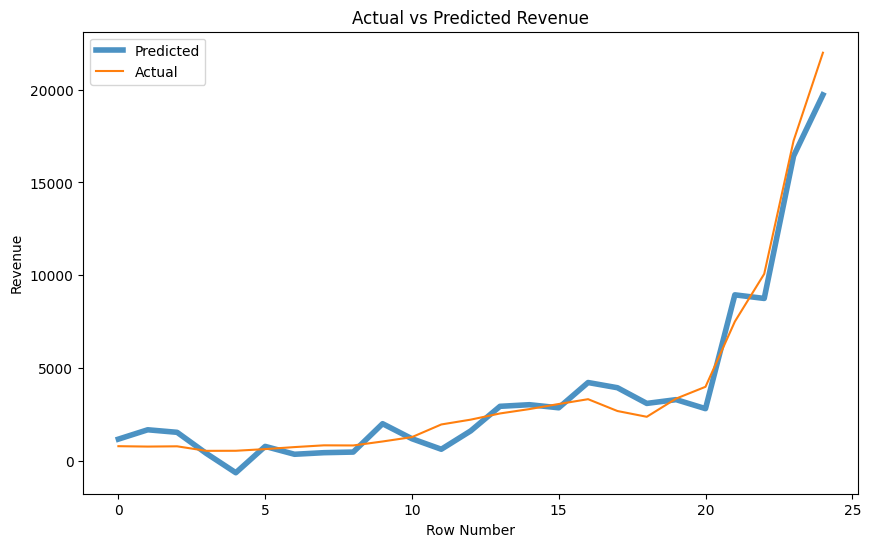

In [32]:
from sklearn.linear_model import LinearRegression
max_row_number = len(merge_df)
test_set_row_number = max_row_number - 1
print(f'Test set row number: {test_set_row_number}')
print(f'Max row number: {max_row_number}')
pred_row_number = test_set_row_number
max_train_row_number = test_set_row_number-test_set_row_len
print(f'Max train row number: {max_train_row_number}')
print(f'Pred row number: {pred_row_number}')
X = merge_df[original_features]

X_train = X.iloc[:max_train_row_number]
y_train = merge_df["NVDA"].iloc[:max_train_row_number]

X_test = X.iloc[max_train_row_number:test_set_row_number]
y_test = merge_df["NVDA"].iloc[max_train_row_number:test_set_row_number]

X_pred = X.iloc[pred_row_number:]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print(f'Predicted (Row 24): {y_pred_test}, Actual: {y_test.to_numpy()}')

y_pred_next = model.predict(X_pred)[0]
if DATACENTER_ONLY:
    y_pred_next = y_pred_next + last_nvda_non_datacenter

print(f'Predicted NVIDIA Revenue for Row 25: {y_pred_next}')

# Predicted (Row 24): 24875.60125209669, Actual: 26044.0
absolute_error = np.mean(abs(y_test - y_pred_test))

print(f'Absolute Error: {absolute_error}')

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

plot_actual_vs_predicted(pred_train, pred_test, y_train, y_test)

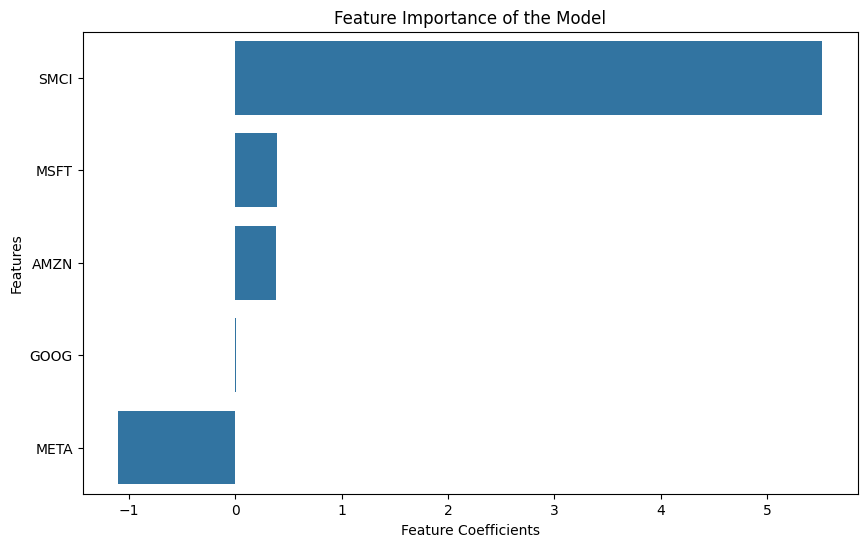

In [33]:


plot_feature_importance(model, X)

In [34]:
from sklearn.linear_model import LinearRegression

max_row_number = len(merge_df)
test_set_row_number = max_row_number - 1
print(f'Test set row number: {test_set_row_number}')
print(f'Max row number: {max_row_number}')
pred_row_number = test_set_row_number
max_train_row_number = test_set_row_number-test_set_row_len
print(f'Max train row number: {max_train_row_number}')
print(f'Pred row number: {pred_row_number}')

X = merge_df[original_features]

X_train = X.iloc[20:max_train_row_number]
y_train = merge_df["NVDA"].iloc[20:max_train_row_number]

X_test = X.iloc[max_train_row_number:test_set_row_number]
y_test = merge_df["NVDA"].iloc[max_train_row_number:test_set_row_number]

X_pred = X.iloc[pred_row_number:]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print(f'Predicted (Row 24): {y_pred_test}, Actual: {y_test.to_numpy()}')

y_pred_next = model.predict(X_pred)[0]
if DATACENTER_ONLY:
    y_pred_next = y_pred_next + last_nvda_non_datacenter

print(f'Predicted NVIDIA Revenue for Row 25: {y_pred_next}')

# Predicted (Row 24): 24875.60125209669, Actual: 26044.0


Test set row number: 25
Max row number: 26
Max train row number: 24
Pred row number: 25
Predicted (Row 24): [19521.58191095], Actual: [21981.136]
Predicted NVIDIA Revenue for Row 25: 29598.171215997987


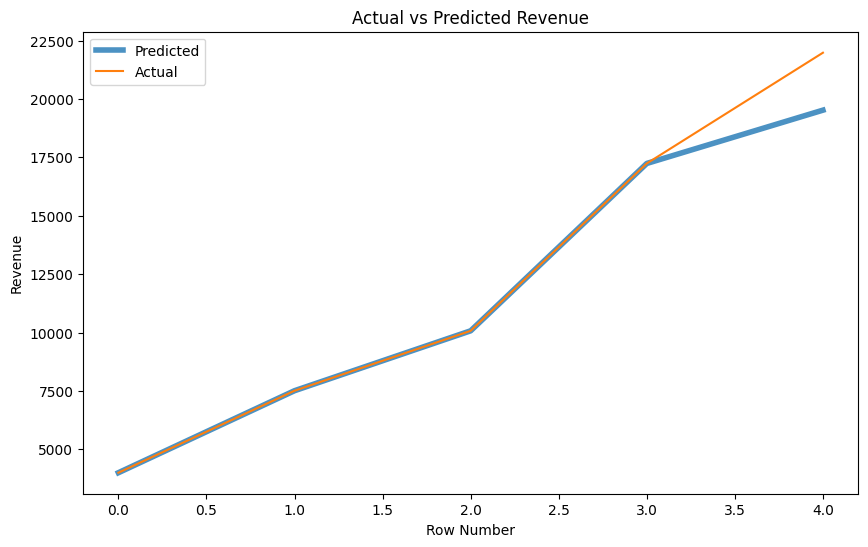

In [35]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

plot_actual_vs_predicted(pred_train, pred_test, y_train, y_test)

In [36]:
merge_df

,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,AWS,AMZN_Total,AMZN-Non-AWS,AWS_PPE_Percentage,NVDA_datacenter_percentage,entire_NVDA_revenue
0,2018Q1,2993.0,1064.234921,7269.0,801.750,2812.0,835.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,3207.0
1,2018Q2,3980.0,1150.872307,5507.0,780.750,3460.0,981.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,3123.0
2,2018Q3,3602.0,990.085807,5282.0,795.250,3342.0,971.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,3181.0
3,2018Q4,3707.0,1217.606510,7081.0,551.250,4301.0,931.0,1000,0,0,0,0,0,0,2445.750000,6267.000000,3821.25,0.390258,25.0,2205.0
4,2019Q1,2565.0,1093.004797,4638.0,555.000,3837.0,743.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,25.0,2220.0
5,2019Q2,4051.0,1061.672796,6126.0,644.750,3633.0,854.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,25.0,2579.0
6,2019Q3,3385.0,1359.728496,-10764.0,753.500,3532.0,799.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,25.0,3014.0
7,2019Q4,3545.0,1582.667733,23548.0,847.665,4100.0,870.0,0,1000,0,0,0,0,0,3014.500000,7504.500000,4490.00,0.401692,27.3,3105.0
8,2020Q1,3767.0,1521.378866,6005.0,840.840,3558.0,772.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284,27.3,3080.0
9,2020Q2,4744.0,1853.795103,5391.0,1055.418,3255.0,896.0,0,0,1000,0,0,0,0,4132.500000,14744.000000,10611.50,0.280284,27.3,3866.0


In [37]:
chatgpt_appearance_quarter = pd.Period("2022Q4")
chatgpt_appearance_quarter

Period('2022Q4', 'Q-DEC')

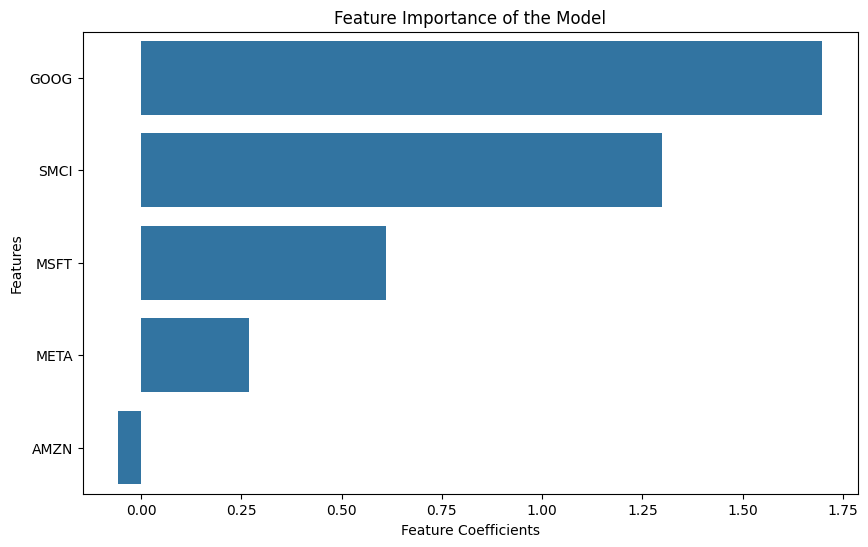

In [38]:
plot_feature_importance(model, X)

In [39]:
merge_df = merge_df.copy()
for feature in original_features:
    merge_df[feature] = fill_nan_with_average(merge_df[feature])
    # chatgpt_excess_revenue_compared or revenue to average from previous year
    merge_df[f"{feature}-excess-feature"] = 0
    avg_1_year_feature_before_gpt = merge_df[
        merge_df["year-quarter"] <= chatgpt_appearance_quarter
    ].iloc[-4:][feature].mean()
    print(f"Average of {feature} before GPT: {avg_1_year_feature_before_gpt}")
    merge_df[f"{feature}-excess-feature"] = np.where(merge_df["year-quarter"] > chatgpt_appearance_quarter, merge_df[feature] - merge_df[feature].mean(), 0)

    # remaining feature after subtracting the excess feature

    merge_df[f"{feature}-remaining-feature"] = merge_df[feature] - merge_df[f"{feature}-excess-feature"]
    



merge_df

Average of AMZN before GPT: 6651.897540107831
Average of GOOG before GPT: 7871.25
Average of MSFT before GPT: 6169.5
Average of META before GPT: 7796.5
Average of SMCI before GPT: 1661.25


,year-quarter,MSFT,AMZN,GOOG,NVDA,META,SMCI,year_2018,year_2019,year_2020,...,AMZN-excess-feature,AMZN-remaining-feature,GOOG-excess-feature,GOOG-remaining-feature,MSFT-excess-feature,MSFT-remaining-feature,META-excess-feature,META-remaining-feature,SMCI-excess-feature,SMCI-remaining-feature
0,2018Q1,2993.0,1064.234921,7269.0,801.750,2812.0,835.0,1000,0,0,...,0.000000,1064.234921,0.000000,7269.000000,0.000000,2993.000000,0.000000,2812.000000,0.000000,835.000000
1,2018Q2,3980.0,1150.872307,5507.0,780.750,3460.0,981.0,1000,0,0,...,0.000000,1150.872307,0.000000,5507.000000,0.000000,3980.000000,0.000000,3460.000000,0.000000,981.000000
2,2018Q3,3602.0,990.085807,5282.0,795.250,3342.0,971.0,1000,0,0,...,0.000000,990.085807,0.000000,5282.000000,0.000000,3602.000000,0.000000,3342.000000,0.000000,971.000000
3,2018Q4,3707.0,1217.606510,7081.0,551.250,4301.0,931.0,1000,0,0,...,0.000000,1217.606510,0.000000,7081.000000,0.000000,3707.000000,0.000000,4301.000000,0.000000,931.000000
4,2019Q1,2565.0,1093.004797,4638.0,555.000,3837.0,743.0,0,1000,0,...,0.000000,1093.004797,0.000000,4638.000000,0.000000,2565.000000,0.000000,3837.000000,0.000000,743.000000
5,2019Q2,4051.0,1061.672796,6126.0,644.750,3633.0,854.0,0,1000,0,...,0.000000,1061.672796,0.000000,6126.000000,0.000000,4051.000000,0.000000,3633.000000,0.000000,854.000000
6,2019Q3,3385.0,1359.728496,-10764.0,753.500,3532.0,799.0,0,1000,0,...,0.000000,1359.728496,0.000000,-10764.000000,0.000000,3385.000000,0.000000,3532.000000,0.000000,799.000000
7,2019Q4,3545.0,1582.667733,23548.0,847.665,4100.0,870.0,0,1000,0,...,0.000000,1582.667733,0.000000,23548.000000,0.000000,3545.000000,0.000000,4100.000000,0.000000,870.000000
8,2020Q1,3767.0,1521.378866,6005.0,840.840,3558.0,772.0,0,0,1000,...,0.000000,1521.378866,0.000000,6005.000000,0.000000,3767.000000,0.000000,3558.000000,0.000000,772.000000
9,2020Q2,4744.0,1853.795103,5391.0,1055.418,3255.0,896.0,0,0,1000,...,0.000000,1853.795103,0.000000,5391.000000,0.000000,4744.000000,0.000000,3255.000000,0.000000,896.000000


Index(['AMZN-excess-feature', 'GOOG-excess-feature', 'MSFT-excess-feature',
       'META-excess-feature', 'SMCI-excess-feature', 'AMZN-remaining-feature',
       'GOOG-remaining-feature', 'MSFT-remaining-feature',
       'META-remaining-feature', 'SMCI-remaining-feature', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'year_2022', 'year_2023',
       'year_2024'],
      dtype='object')
Predicted (Row 24): [19250.86370851], Actual: [21981.136]
Predicted NVIDIA Revenue for Row 25: 31883.064091140564
Absolute Error: 2730.2722914943006


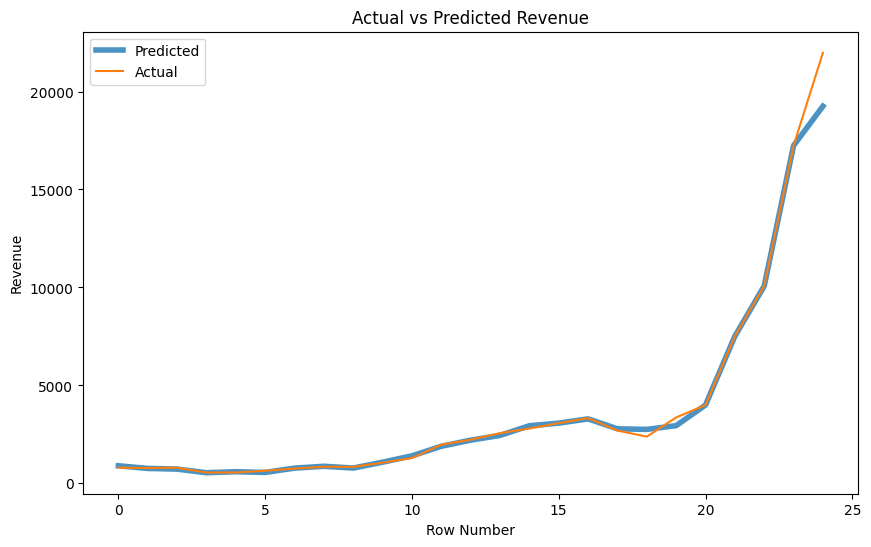

In [41]:
excess_features = [f"{feature}-excess-feature" for feature in original_features]
remaining_features = [f"{feature}-remaining-feature" for feature in original_features]

y = merge_df["NVDA"]
if USE_YEARS_FEATURES:
    X = merge_df[excess_features+remaining_features+year_columns]
else:
    X = merge_df[excess_features+remaining_features]
print(X.columns)
X_train = X.iloc[:max_train_row_number]
y_train = y.iloc[:max_train_row_number]
X_test = X.iloc[max_train_row_number:test_set_row_number]
y_test = y.iloc[max_train_row_number:test_set_row_number]
X_pred = X.iloc[pred_row_number:]

if USE_YEARS_FEATURES:
    model = LinearRegression()
else:
    model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print(f'Predicted (Row 24): {y_pred_test}, Actual: {y_test.to_numpy()}')

y_pred_next = model.predict(X_pred)[0]
if DATACENTER_ONLY:
    y_pred_next = y_pred_next + last_nvda_non_datacenter
print(f'Predicted NVIDIA Revenue for Row 25: {y_pred_next}')

absolute_error = np.mean(abs(y_test - y_pred_test))
print(f'Absolute Error: {absolute_error}')

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

plot_actual_vs_predicted(pred_train, pred_test, y_train, y_test)

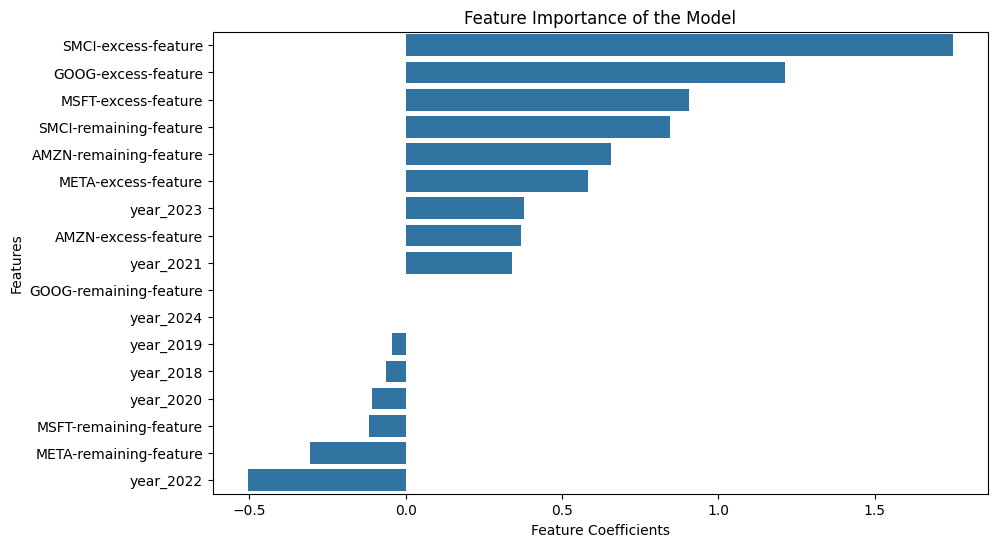

In [42]:
plot_feature_importance(model, X)


### Prod model

Predicted NVIDIA Revenue for Row 25: 35290.855700118016
[31227.99170012]


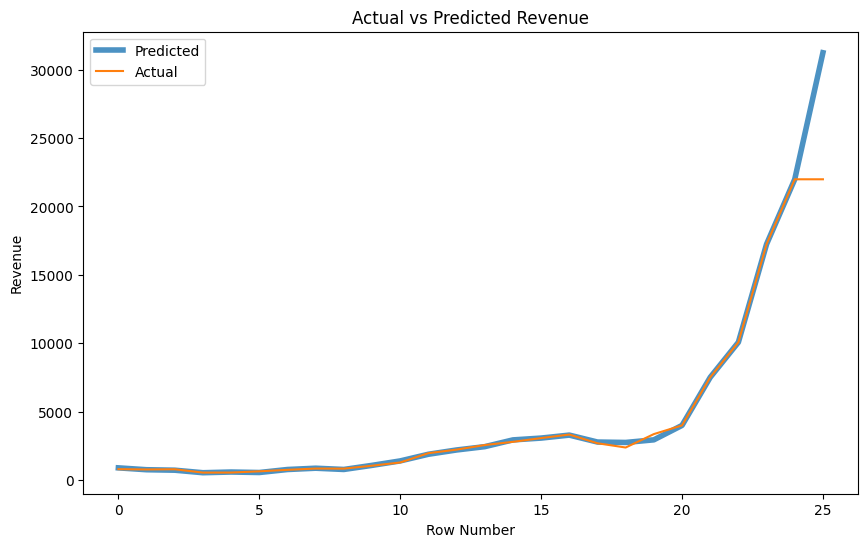

In [44]:
X_train = X.iloc[:pred_row_number]
y_train = y.iloc[:pred_row_number]
X_pred = X.iloc[pred_row_number:]

if USE_YEARS_FEATURES:
    model = LinearRegression()
else:
    model = LinearRegression()
model.fit(X_train, y_train)

y_pred_next = model.predict(X_pred)[0]
if DATACENTER_ONLY:
    y_pred_next = y_pred_next + last_nvda_non_datacenter
print(f'Predicted NVIDIA Revenue for Row 25: {y_pred_next}')

pred_train = model.predict(X_train)
y_pred_next = model.predict(X_pred)
print(y_pred_next)
plot_actual_vs_predicted(pred_train, y_pred_next, y_train, y_test)

In [45]:
merge_df[excess_features].iloc[18:]

,AMZN-excess-feature,GOOG-excess-feature,MSFT-excess-feature,META-excess-feature,SMCI-excess-feature
18,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000
20,2631.808819,-808.769231,709.615385,1611.346154,-234.923077
21,1265.916588,-209.769231,3045.615385,922.346154,666.076923
22,1721.213998,957.230769,4019.615385,1284.346154,601.076923
23,2777.236773,3921.230769,3837.615385,2380.346154,2146.076923
24,4000.794045,4914.230769,5054.615385,1188.346154,2332.076923
25,6458.794045,6088.230769,7975.615385,2961.346154,3792.076923


Index(['AMZN-excess-feature', 'GOOG-excess-feature', 'MSFT-excess-feature',
       'META-excess-feature', 'SMCI-excess-feature'],
      dtype='object')
Predicted (Row 24): [19521.58191095], Actual: [21981.136]
Predicted NVIDIA Revenue for Row 25: 29598.17121599799
Absolute Error: 2459.5540890545053


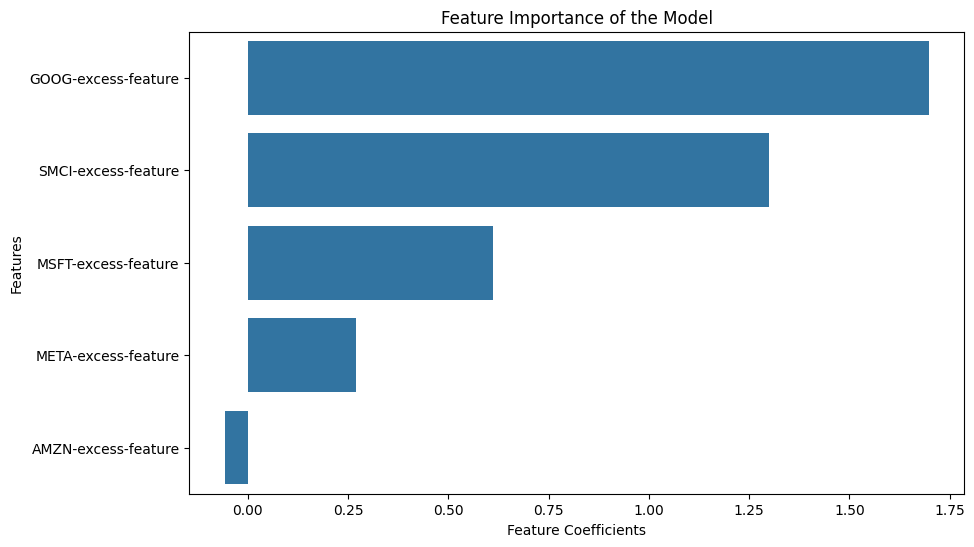

In [46]:
excess_features = [f"{feature}-excess-feature" for feature in original_features]
remaining_features = [f"{feature}-remaining-feature" for feature in original_features]

y = merge_df["NVDA"]

X = merge_df[excess_features]
print(X.columns)
X_train = X.iloc[20:max_train_row_number]
y_train = y.iloc[20:max_train_row_number]
X_test = X.iloc[max_train_row_number:test_set_row_number]
y_test = y.iloc[max_train_row_number:test_set_row_number]
X_pred = X.iloc[pred_row_number:]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

print(f'Predicted (Row 24): {y_pred_test}, Actual: {y_test.to_numpy()}')

y_pred_next = model.predict(X_pred)[0]

if DATACENTER_ONLY:
    y_pred_next = y_pred_next + last_nvda_non_datacenter
print(f'Predicted NVIDIA Revenue for Row 25: {y_pred_next}')


absolute_error = np.mean(abs(y_test - y_pred_test))

print(f"Absolute Error: {absolute_error}")

plot_feature_importance(model, X)

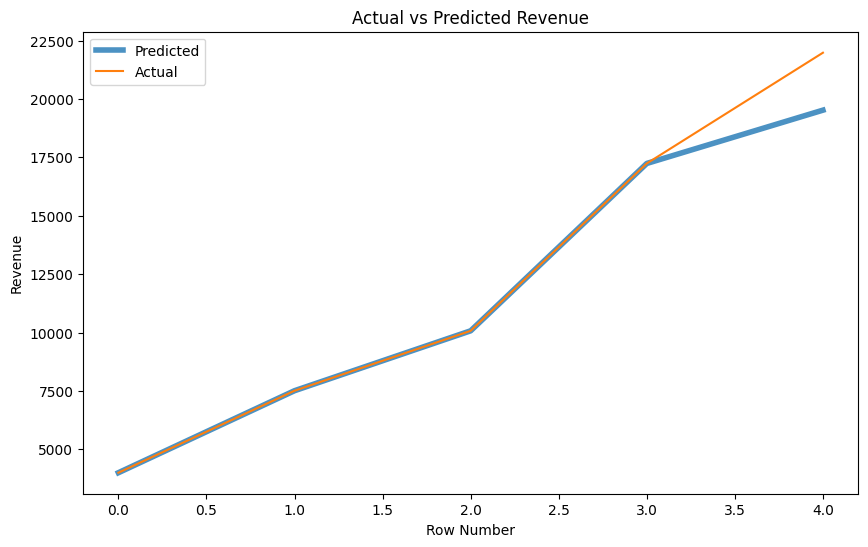

In [47]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

plot_actual_vs_predicted(pred_train, pred_test, y_train, y_test)